# Add more training data

We obtain the set of parameters with smallest RMSE during the the hyperparameter tuning job. This notebook trains the model with this set of hyperparameters. The SMAPE scores improved around 20% for all time series buckets.

- This notebook we train a deepAR model using 2Years/ over all available of wiki-projects pageview data within requested time range, and test the model with both wiki and synthetic data.  
- Model pipeline: Request to Wiki REST api >> save_jason() to S3 bucket >> train model >> deploy trained model on Sagemaker, create endpoint >> request inference >> get prediction >> evaluation with test metric 

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

In [2]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.6.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - s3fs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.12.5  |                0         123 KB

The following packages will be UPDATED:

    ca-certificates: 2018.8.24-ha4d7672_0 conda-forge --> 2018.12.5-0      
    certifi:         2018.8.24-py36_1     conda-forge --> 2018.11.29-py36_0
    openssl:         1.0.2p-h470a237_0    conda-forge --> 1.0.2p-h14c3975_0
    s3fs:            0.1.5-py36_0                     --> 0.2.0-py36_0     


ca-certificates-2018 | 123 KB    | ##################################### | 100% 

FileNotFoundError(2, 'No such 

In [3]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [4]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Predict setting

We predict the next 48 points of time series.
The time series that we use have hourly granularity.

In [6]:
freq = 'H'
prediction_length = 48

`context_length`: how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`.

In [7]:
context_length = 118

Useful functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3. (didn't call during this example)

In [8]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

### Get wikimedia pageview data from its REST API
We request the http requests sent by users to wiki projects. The output will be a json file with required format, each line contains hourly pageview numbers from `start` to `end`. Output files are saved in a S3 bucket.
- (A side note: wiki api allows <b>100</b> requests/s maximum, don't get blacklisted.)
- (Anote side note: the response will be json objects, each has a time stamp and corresponding time series values such as pageview, the maximum number of returned objects is 5000 that's why I use time delta = 200 days = 4800 objects for each request)

In [9]:
import datetime
import requests
import json
import time

all_data = []
project_list = []
delta = datetime.timedelta(days=199)
hour = datetime.timedelta(hours=1)
zero = datetime.timedelta(hours=0)


def save_json(start, end, out_path, input_path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    expected_size = ((end_date - start_date).days + 1) * 24

    # provide wiki-project list here!
    with open(input_path) as f:
        projects = f.read().splitlines()

    for item in projects:
        data = get_single_views(item, start_date, end_date)
        if len(data['target']) == expected_size:
            all_data.append(data)
            project_list.append(item)

    # convert all items to JSON and write to a file
    print('saving data')
    print(project_list)
    with open(input_path[:-4] + '-' + str(start) + '-' + str(end) + '-get.txt', 'w') as f:
        for item in project_list:
            f.write("%s\n" % item)
    with s3filesystem.open(out_path, 'w') as outfile:
        outfile.write('\n'.join(json.dumps(i) for i in all_data) + '\n')
    all_data.clear()
    project_list.clear()


def get_single_views(item, start_date, end_date):
    base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' \
               + item \
               + '/all-access/user/hourly/'
    # dict is used to save JSON of each domain
    data = dict()
    data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
    data['target'] = []

    while start_date <= end_date:
        if start_date + delta <= end_date:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + (start_date + delta).strftime('%Y%m%d') + '23'
            end_check = start_date + delta + 23 * hour
        else:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + end_date.strftime('%Y%m%d') + '23'
            end_check = end_date + 23 * hour
        # make a API request here!!!
        response = requests.get(final_url)
        time.sleep(0.05)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print("<-----Error---->: " + final_url + str(e))
            break
        print('<-----OK----->' + final_url)  # debug
        output = response.json()
        print('processed data points: ' + str(len(output['items'])))  # debug
        temp = start_date - hour
        for i in output['items']:
            curr = datetime.datetime.strptime(i['timestamp'], '%Y%m%d%H')
            while curr - temp > hour:
                data['target'].append(None)
                temp += hour
            data['target'].append(i['views'])
            temp = curr

        while (end_check - temp) > zero:
            data['target'].append(None)
            temp += hour

        start_date += datetime.timedelta(days=200)

    return data

In [10]:
# train_start = '20160101'
# train_end = '20171231'
# save_json(train_start,train_end,s3_data_path + "/train_0toNaN/train.json", 'wp_full.txt')
# test_start = '20180101'
# test_end = '20181231'
# save_json(test_start,test_end,s3_data_path + "/test_0toNaN/test.json", 'wp_full.txt')

### Train a model

In [11]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [12]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "35",
    "num_layers": "2",
    "likelihood": "student-t",
    "epochs": "39",
    "mini_batch_size": "85",
    "learning_rate": "0.0030902721170490166",
    "dropout_rate": "0.052384954005170334",
    "early_stopping_patience": "10"
}

In [13]:
estimator.set_hyperparameters(**hyperparameters)

In [14]:
data_channels = {
    "train": "s3://{}/train_more/".format(s3_data_path),
    "test": "s3://{}/test_0toNaN/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-02-05-03-33-24-323


2019-02-05 03:33:24 Starting - Starting the training job...
2019-02-05 03:33:37 Starting - Launching requested ML instances......
2019-02-05 03:34:37 Starting - Preparing the instances for training......
2019-02-05 03:35:40 Downloading - Downloading input data
2019-02-05 03:35:40 Training - Downloading the training image.....
Arguments: train
[02/05/2019 03:36:33 INFO 139671431767872] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[02/05/2019 03:36:33 INFO 13

[02/05/2019 03:37:34 INFO 139671431767872] Epoch[1] Batch[15] avg_epoch_loss=5.399210
[02/05/2019 03:37:34 INFO 139671431767872] Epoch[1] Batch [15]#011Speed: 232.04 samples/sec#011loss=5.709476
[02/05/2019 03:37:38 INFO 139671431767872] Epoch[1] Batch[20] avg_epoch_loss=5.478277
[02/05/2019 03:37:38 INFO 139671431767872] Epoch[1] Batch [20]#011Speed: 95.20 samples/sec#011loss=5.731292
[02/05/2019 03:37:40 INFO 139671431767872] Epoch[1] Batch[25] avg_epoch_loss=5.440883
[02/05/2019 03:37:40 INFO 139671431767872] Epoch[1] Batch [25]#011Speed: 231.91 samples/sec#011loss=5.283830
[02/05/2019 03:37:44 INFO 139671431767872] Epoch[1] Batch[30] avg_epoch_loss=5.392081
[02/05/2019 03:37:44 INFO 139671431767872] Epoch[1] Batch [30]#011Speed: 95.29 samples/sec#011loss=5.138308
[02/05/2019 03:37:46 INFO 139671431767872] Epoch[1] Batch[35] avg_epoch_loss=5.277439
[02/05/2019 03:37:46 INFO 139671431767872] Epoch[1] Batch [35]#011Speed: 232.39 samples/sec#011loss=4.566661
[02/05/2019 03:37:49 INFO 1

[02/05/2019 03:38:54 INFO 139671431767872] Epoch[4] Batch[15] avg_epoch_loss=5.219463
[02/05/2019 03:38:54 INFO 139671431767872] Epoch[4] Batch [15]#011Speed: 227.66 samples/sec#011loss=5.500759
[02/05/2019 03:38:58 INFO 139671431767872] Epoch[4] Batch[20] avg_epoch_loss=5.274750
[02/05/2019 03:38:58 INFO 139671431767872] Epoch[4] Batch [20]#011Speed: 95.03 samples/sec#011loss=5.451668
[02/05/2019 03:39:00 INFO 139671431767872] Epoch[4] Batch[25] avg_epoch_loss=5.221274
[02/05/2019 03:39:00 INFO 139671431767872] Epoch[4] Batch [25]#011Speed: 228.68 samples/sec#011loss=4.996674
[02/05/2019 03:39:04 INFO 139671431767872] Epoch[4] Batch[30] avg_epoch_loss=5.156904
[02/05/2019 03:39:04 INFO 139671431767872] Epoch[4] Batch [30]#011Speed: 97.76 samples/sec#011loss=4.822182
[02/05/2019 03:39:06 INFO 139671431767872] Epoch[4] Batch[35] avg_epoch_loss=5.055138
[02/05/2019 03:39:06 INFO 139671431767872] Epoch[4] Batch [35]#011Speed: 232.88 samples/sec#011loss=4.424190
[02/05/2019 03:39:09 INFO 1

[02/05/2019 03:40:14 INFO 139671431767872] Epoch[7] Batch[15] avg_epoch_loss=5.142422
[02/05/2019 03:40:14 INFO 139671431767872] Epoch[7] Batch [15]#011Speed: 234.38 samples/sec#011loss=5.554325
[02/05/2019 03:40:18 INFO 139671431767872] Epoch[7] Batch[20] avg_epoch_loss=5.164309
[02/05/2019 03:40:18 INFO 139671431767872] Epoch[7] Batch [20]#011Speed: 95.45 samples/sec#011loss=5.234349
[02/05/2019 03:40:20 INFO 139671431767872] Epoch[7] Batch[25] avg_epoch_loss=5.148571
[02/05/2019 03:40:20 INFO 139671431767872] Epoch[7] Batch [25]#011Speed: 234.15 samples/sec#011loss=5.082470
[02/05/2019 03:40:25 INFO 139671431767872] Epoch[7] Batch[30] avg_epoch_loss=5.092081
[02/05/2019 03:40:25 INFO 139671431767872] Epoch[7] Batch [30]#011Speed: 93.03 samples/sec#011loss=4.798335
[02/05/2019 03:40:26 INFO 139671431767872] Epoch[7] Batch[35] avg_epoch_loss=5.031172
[02/05/2019 03:40:26 INFO 139671431767872] Epoch[7] Batch [35]#011Speed: 236.43 samples/sec#011loss=4.653533
[02/05/2019 03:40:29 INFO 1

[02/05/2019 03:41:35 INFO 139671431767872] Epoch[10] Batch[15] avg_epoch_loss=5.198134
[02/05/2019 03:41:35 INFO 139671431767872] Epoch[10] Batch [15]#011Speed: 227.56 samples/sec#011loss=5.675426
[02/05/2019 03:41:39 INFO 139671431767872] Epoch[10] Batch[20] avg_epoch_loss=5.177812
[02/05/2019 03:41:39 INFO 139671431767872] Epoch[10] Batch [20]#011Speed: 94.80 samples/sec#011loss=5.112782
[02/05/2019 03:41:41 INFO 139671431767872] Epoch[10] Batch[25] avg_epoch_loss=5.189827
[02/05/2019 03:41:41 INFO 139671431767872] Epoch[10] Batch [25]#011Speed: 230.02 samples/sec#011loss=5.240289
[02/05/2019 03:41:45 INFO 139671431767872] Epoch[10] Batch[30] avg_epoch_loss=5.124192
[02/05/2019 03:41:45 INFO 139671431767872] Epoch[10] Batch [30]#011Speed: 93.57 samples/sec#011loss=4.782888
[02/05/2019 03:41:47 INFO 139671431767872] Epoch[10] Batch[35] avg_epoch_loss=5.048372
[02/05/2019 03:41:47 INFO 139671431767872] Epoch[10] Batch [35]#011Speed: 230.58 samples/sec#011loss=4.578289
[02/05/2019 03:41

[02/05/2019 03:43:17 INFO 139671431767872] Epoch[14] Batch[5] avg_epoch_loss=4.853886
[02/05/2019 03:43:17 INFO 139671431767872] Epoch[14] Batch [5]#011Speed: 227.29 samples/sec#011loss=4.853886
[02/05/2019 03:43:21 INFO 139671431767872] Epoch[14] Batch[10] avg_epoch_loss=5.012107
[02/05/2019 03:43:21 INFO 139671431767872] Epoch[14] Batch [10]#011Speed: 97.58 samples/sec#011loss=5.201973
[02/05/2019 03:43:23 INFO 139671431767872] Epoch[14] Batch[15] avg_epoch_loss=5.146518
[02/05/2019 03:43:23 INFO 139671431767872] Epoch[14] Batch [15]#011Speed: 228.45 samples/sec#011loss=5.442220
[02/05/2019 03:43:27 INFO 139671431767872] Epoch[14] Batch[20] avg_epoch_loss=5.182048
[02/05/2019 03:43:27 INFO 139671431767872] Epoch[14] Batch [20]#011Speed: 95.58 samples/sec#011loss=5.295744
[02/05/2019 03:43:29 INFO 139671431767872] Epoch[14] Batch[25] avg_epoch_loss=5.147159
[02/05/2019 03:43:29 INFO 139671431767872] Epoch[14] Batch [25]#011Speed: 228.99 samples/sec#011loss=5.000625
[02/05/2019 03:43:3

[02/05/2019 03:44:57 INFO 139671431767872] Epoch[17] Batch[30] avg_epoch_loss=5.151622
[02/05/2019 03:44:57 INFO 139671431767872] Epoch[17] Batch [30]#011Speed: 91.19 samples/sec#011loss=4.981889
[02/05/2019 03:44:59 INFO 139671431767872] Epoch[17] Batch[35] avg_epoch_loss=5.024498
[02/05/2019 03:44:59 INFO 139671431767872] Epoch[17] Batch [35]#011Speed: 230.10 samples/sec#011loss=4.236327
[02/05/2019 03:45:01 INFO 139671431767872] Epoch[17] Batch[40] avg_epoch_loss=4.948239
[02/05/2019 03:45:01 INFO 139671431767872] Epoch[17] Batch [40]#011Speed: 178.38 samples/sec#011loss=4.399170
[02/05/2019 03:45:02 INFO 139671431767872] processed a total of 3583 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 28816.789865493774, "sum": 28816.789865493774, "min": 28816.789865493774}}, "EndTime": 1549338302.537616, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1549338273.720361}

[02/05/2019 03:45:02 INFO 139671431767872] #throug

[02/05/2019 03:46:28 INFO 139671431767872] Epoch[21] Batch[5] avg_epoch_loss=4.699201
[02/05/2019 03:46:28 INFO 139671431767872] Epoch[21] Batch [5]#011Speed: 227.53 samples/sec#011loss=4.699201
[02/05/2019 03:46:33 INFO 139671431767872] Epoch[21] Batch[10] avg_epoch_loss=4.840949
[02/05/2019 03:46:33 INFO 139671431767872] Epoch[21] Batch [10]#011Speed: 94.06 samples/sec#011loss=5.011046
[02/05/2019 03:46:35 INFO 139671431767872] Epoch[21] Batch[15] avg_epoch_loss=5.022573
[02/05/2019 03:46:35 INFO 139671431767872] Epoch[21] Batch [15]#011Speed: 231.21 samples/sec#011loss=5.422146
[02/05/2019 03:46:39 INFO 139671431767872] Epoch[21] Batch[20] avg_epoch_loss=5.107343
[02/05/2019 03:46:39 INFO 139671431767872] Epoch[21] Batch [20]#011Speed: 91.58 samples/sec#011loss=5.378608
[02/05/2019 03:46:41 INFO 139671431767872] Epoch[21] Batch[25] avg_epoch_loss=5.065895
[02/05/2019 03:46:41 INFO 139671431767872] Epoch[21] Batch [25]#011Speed: 231.18 samples/sec#011loss=4.891813
[02/05/2019 03:46:4

[02/05/2019 03:48:08 INFO 139671431767872] Epoch[24] Batch[30] avg_epoch_loss=5.033420
[02/05/2019 03:48:08 INFO 139671431767872] Epoch[24] Batch [30]#011Speed: 91.05 samples/sec#011loss=4.736510
[02/05/2019 03:48:10 INFO 139671431767872] Epoch[24] Batch[35] avg_epoch_loss=4.941317
[02/05/2019 03:48:10 INFO 139671431767872] Epoch[24] Batch [35]#011Speed: 228.35 samples/sec#011loss=4.370283
[02/05/2019 03:48:13 INFO 139671431767872] Epoch[24] Batch[40] avg_epoch_loss=4.881079
[02/05/2019 03:48:13 INFO 139671431767872] Epoch[24] Batch [40]#011Speed: 159.41 samples/sec#011loss=4.447364
[02/05/2019 03:48:14 INFO 139671431767872] processed a total of 3599 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 27708.226919174194, "sum": 27708.226919174194, "min": 27708.226919174194}}, "EndTime": 1549338494.325301, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1549338466.616588}

[02/05/2019 03:48:14 INFO 139671431767872] #throug

[02/05/2019 03:49:41 INFO 139671431767872] Epoch[28] Batch[5] avg_epoch_loss=4.714818
[02/05/2019 03:49:41 INFO 139671431767872] Epoch[28] Batch [5]#011Speed: 236.66 samples/sec#011loss=4.714818
[02/05/2019 03:49:46 INFO 139671431767872] Epoch[28] Batch[10] avg_epoch_loss=4.805646
[02/05/2019 03:49:46 INFO 139671431767872] Epoch[28] Batch [10]#011Speed: 93.16 samples/sec#011loss=4.914640
[02/05/2019 03:49:47 INFO 139671431767872] Epoch[28] Batch[15] avg_epoch_loss=5.035426
[02/05/2019 03:49:47 INFO 139671431767872] Epoch[28] Batch [15]#011Speed: 234.50 samples/sec#011loss=5.540941
[02/05/2019 03:49:52 INFO 139671431767872] Epoch[28] Batch[20] avg_epoch_loss=5.105444
[02/05/2019 03:49:52 INFO 139671431767872] Epoch[28] Batch [20]#011Speed: 93.20 samples/sec#011loss=5.329500
[02/05/2019 03:49:54 INFO 139671431767872] Epoch[28] Batch[25] avg_epoch_loss=5.074043
[02/05/2019 03:49:54 INFO 139671431767872] Epoch[28] Batch [25]#011Speed: 232.52 samples/sec#011loss=4.942158
[02/05/2019 03:49:5

[02/05/2019 03:51:20 INFO 139671431767872] Epoch[31] Batch[30] avg_epoch_loss=5.090657
[02/05/2019 03:51:20 INFO 139671431767872] Epoch[31] Batch [30]#011Speed: 91.56 samples/sec#011loss=4.930097
[02/05/2019 03:51:22 INFO 139671431767872] Epoch[31] Batch[35] avg_epoch_loss=5.005813
[02/05/2019 03:51:22 INFO 139671431767872] Epoch[31] Batch [35]#011Speed: 227.60 samples/sec#011loss=4.479783
[02/05/2019 03:51:24 INFO 139671431767872] Epoch[31] Batch[40] avg_epoch_loss=4.930437
[02/05/2019 03:51:24 INFO 139671431767872] Epoch[31] Batch [40]#011Speed: 175.14 samples/sec#011loss=4.387731
[02/05/2019 03:51:25 INFO 139671431767872] processed a total of 3581 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 27601.028203964233, "sum": 27601.028203964233, "min": 27601.028203964233}}, "EndTime": 1549338685.507577, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1549338657.906029}

[02/05/2019 03:51:25 INFO 139671431767872] #throug

#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 14146.059036254883, "sum": 14146.059036254883, "min": 14146.059036254883}}, "EndTime": 1549338781.433937, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1549338767.287239}

[02/05/2019 03:53:01 INFO 139671431767872] Number of GPUs being used: 0
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 14467.10991859436, "sum": 14467.10991859436, "min": 14467.10991859436}}, "EndTime": 1549338781.754948, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1549338781.434092}

[02/05/2019 03:53:01 INFO 139671431767872] Serializing to /opt/ml/model/model_algo-1
[02/05/2019 03:53:01 INFO 139671431767872] Saved checkpoint to "/opt/ml/model/model_algo-1-0000.params"
#metrics {"Metrics": {"model.serialize.time": {"count": 1, "max": 36.15403175354004, "sum": 36.15403175354004, "min": 36.15403175354004}}, "EndTime": 1549338781.791216, "Dim

### Create endpoint and predictor

In [15]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-02-05-03-33-24-323
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-02-05-03-33-24-323
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-02-05-03-33-24-323


--------------------------------------------------------------------------!

In [16]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [17]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions, plot and evaluate the results

### Make prediction for `wiki` data

In [18]:
data_location = "s3://{}/test_0toNaN/test.json".format(s3_data_path)
df_ts = pd.read_json(data_location, lines = True)
df_ts.head()

,start,target
0,2018-01-01 00:00:00,"[93, 6, 12, 17, 113, 17, 70, 5, 100, 92, 51, 1..."
1,2018-01-01 00:00:00,"[None, 1, None, None, None, 2, None, None, 1, ..."
2,2018-01-01 00:00:00,"[None, 1, 1, 1, 1, 2, 1, 7, 3, None, 7, 5, 1, ..."
3,2018-01-01 00:00:00,"[69, 74, 102, 102, 104, 65, 65, 79, 55, 108, 2..."
4,2018-01-01 00:00:00,"[None, None, 2, 1, None, 2, 1, 1, None, None, ..."


In [19]:
num_pt = len(df_ts.iloc[1,1])
num_ts = len(df_ts)

time_series_wiki = [] 
for k in range(num_ts):
    t0 = df_ts.iloc[k,0]
    data = df_ts.iloc[k,1]
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
    ts = pd.Series(data=data, index=index)
    ts_0val = ts.replace(to_replace=np.nan, value=0, inplace = False)
    time_series_wiki.append(ts_0val)

In [20]:
time_series_wiki_predict = []
for ts in time_series_wiki:
    # Revert 0 values back to NaN
#     ts_nan = ts.replace(to_replace=0, value=np.nan, inplace = False)
    time_series_wiki_predict.append(ts[:-prediction_length])

In [21]:
# result of prediction will be stored in list_of_wiki_pred
list_of_wiki_pred = []
for i in range(0,len(time_series_wiki_predict)):
    list_of_wiki_pred.append(predictor.predict(time_series_wiki_predict[i:i+1]))
    # The following line is added to avoid time out error.
    time.sleep(0.01) 

### A quick overview of the prediction

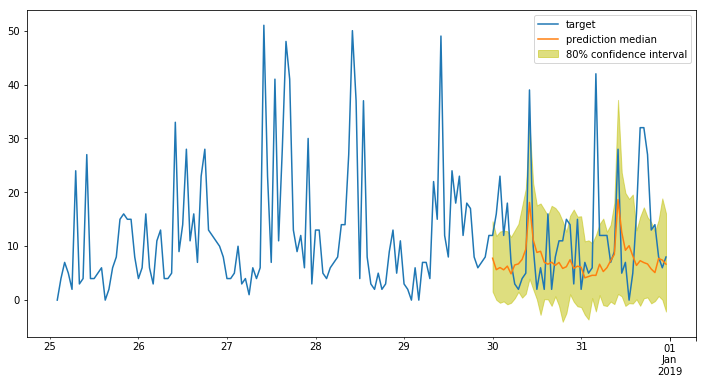

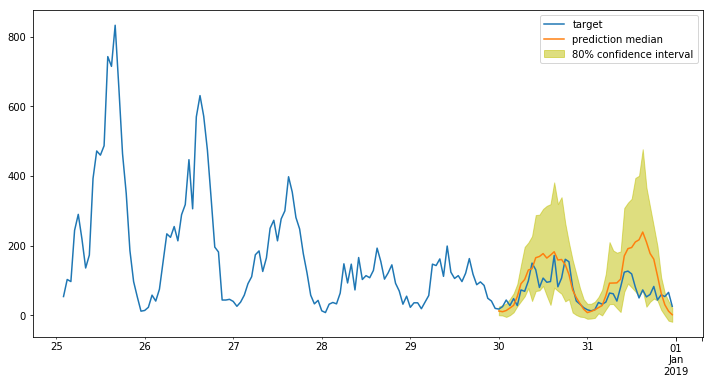

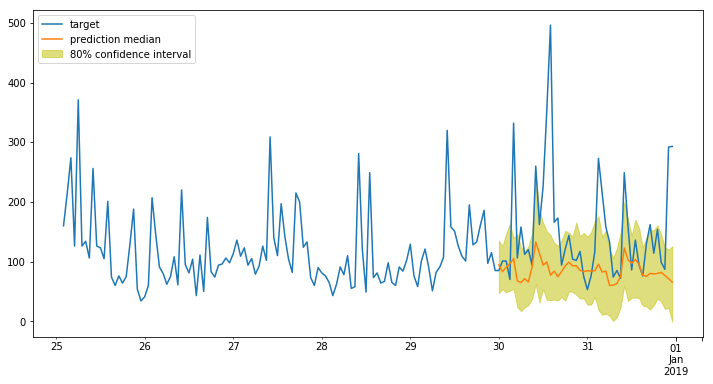

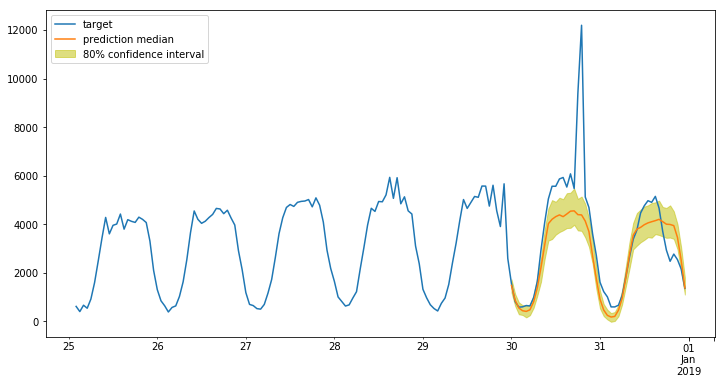

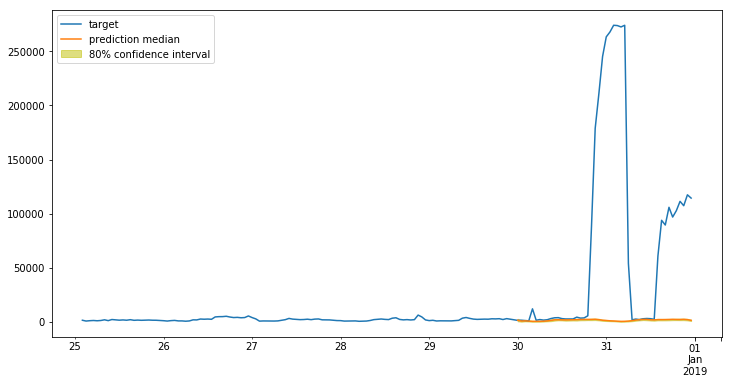

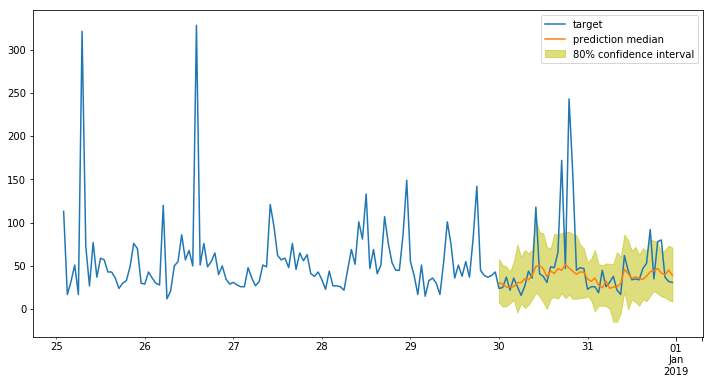

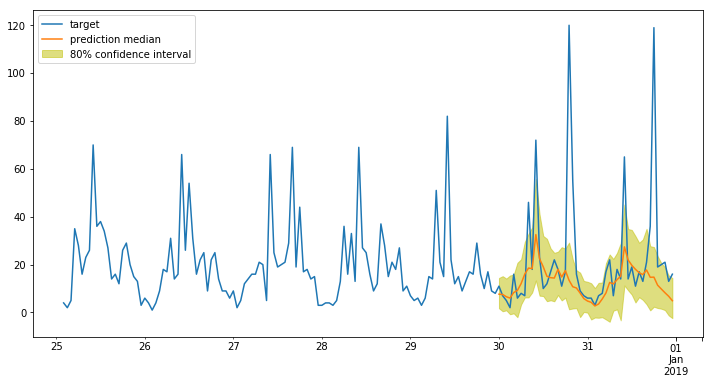

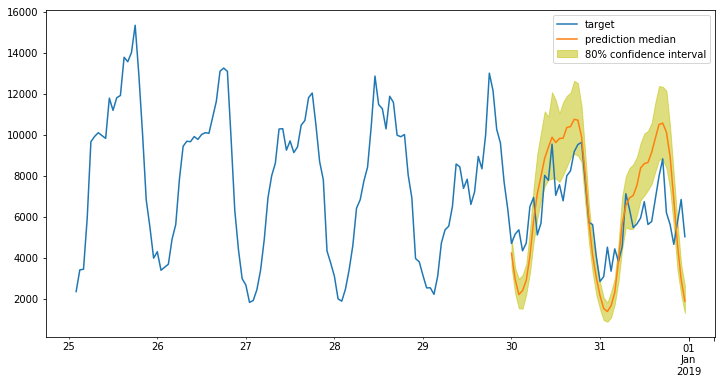

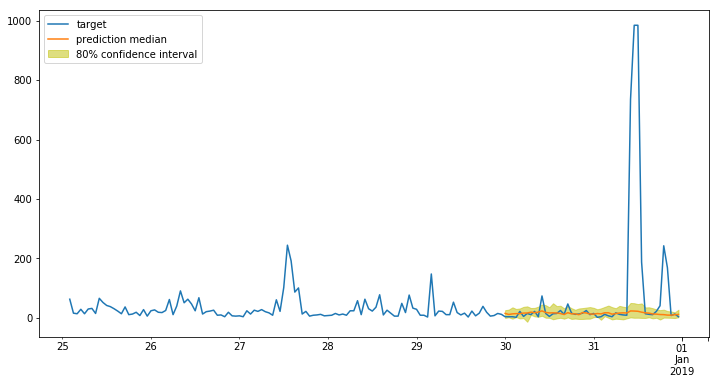

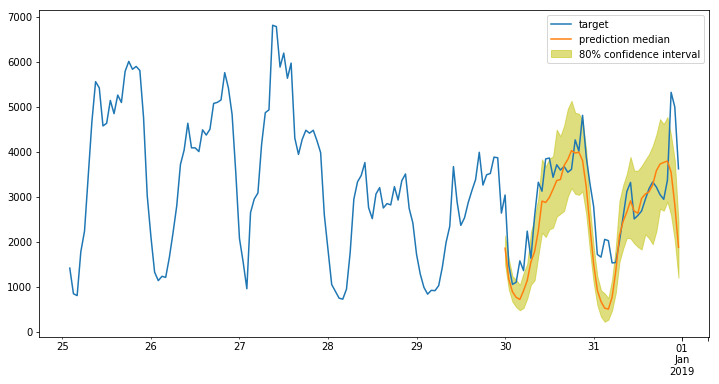

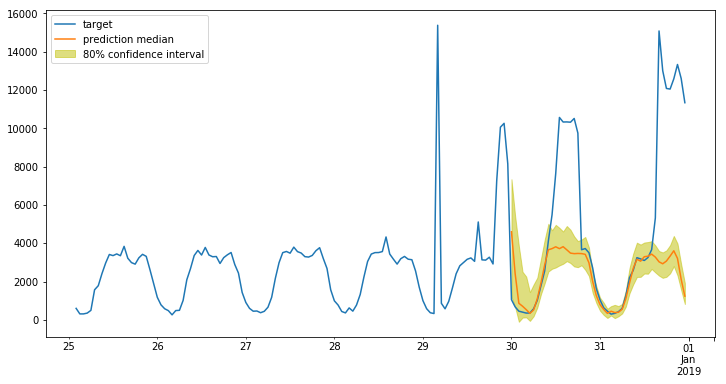

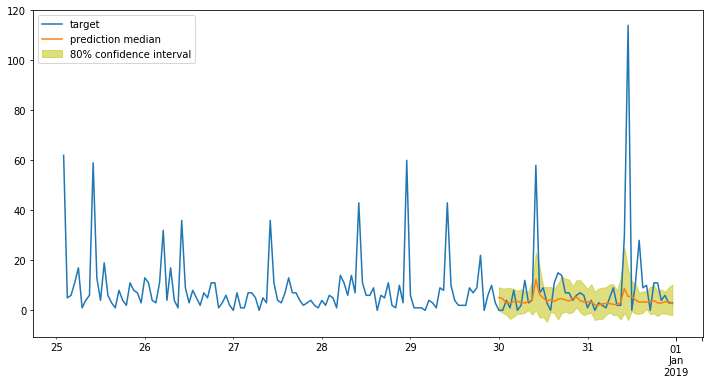

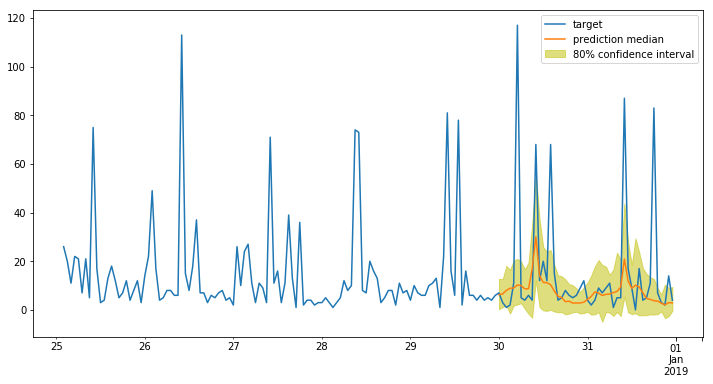

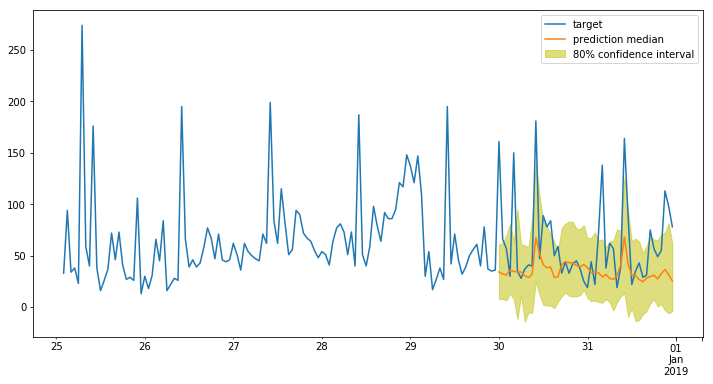

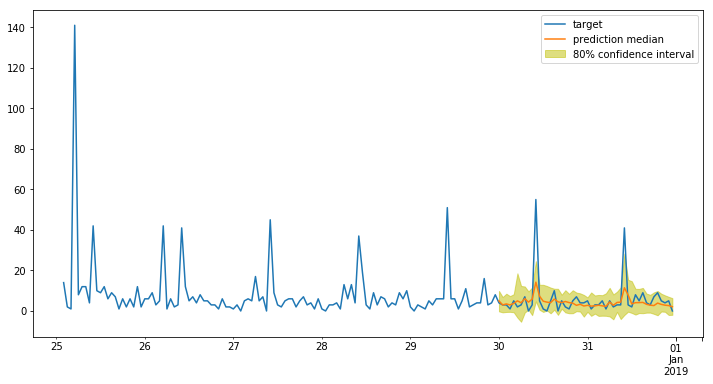

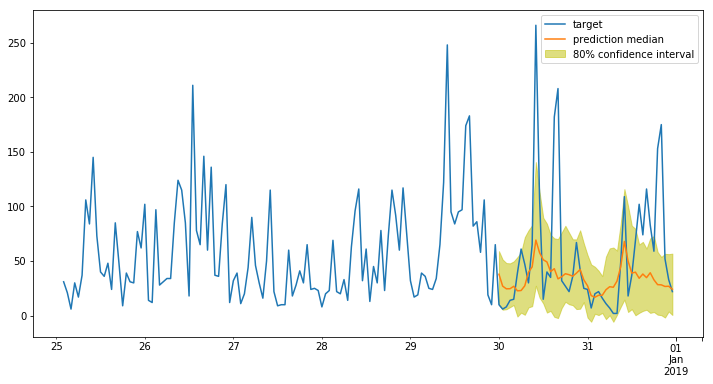

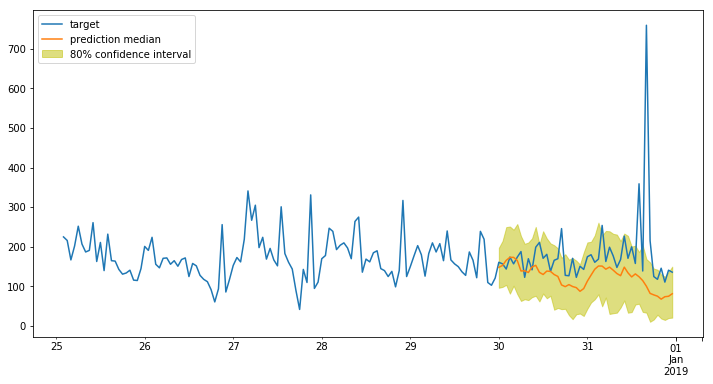

In [22]:
# sample several predicted time series use range(0, len(list_of_wiki_pred), 50)
for k in range(0, len(list_of_wiki_pred), 50):
    plt.figure(figsize=(12,6))
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.legend(loc = 'best')
    plt.show()

### Metrics to evaluate the prediction
- Mean absolute percentage error
- Mean absolute error with log1p
- Symmetric mean absolute percentage error
- Symmetric mean absolute percentage error differentiable
- others?

In [23]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE, rounded up to the closest integer
def rounded_smape(true, predicted):
    true_o = np.int(np.round(true))
    pred_o = np.round(predicted).astype(np.int32)
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# SMAPE stardard definition
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# MAE standard definition
def mape(true, predicted):
    true_o = true
    pred_o = predicted
    denom = np.abs(true_o)
    mape = np.where(denom==0, 0, np.abs(pred_o - true_o) / denom)
    return mape


# MAE on log1p
def mape1p(true, predicted):
    epsilon = 0.1
    true_o = np.log1p(true + epsilon)
    pred_o = np.log1p(predicted + epsilon)
    error = np.where(np.abs(true_o)==0, 0, np.abs(pred_o - true_o) / np.abs(true_o))
#     error = np.abs(true_o - pred_o)/np.abs(true_o)
    return error

In [24]:
# input pd.series in which index = time stamps, value = time series values
# actual_series and pred_series should have exactly matched timestamps

def plot_metrics(actual_series, pred_series):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    metric_smape = differentiable_smape(actual_series.values, pred_series.values)
    metric_mape = mape(actual_series.values, pred_series.values)
    metric_maelog1p = mape1p(actual_series.values, pred_series.values)
    metric_smape_orig = smape(actual_series.values, pred_series.values)
    plt.figure(figsize=(12,6))
    plt.plot(pred_series.index, metric_smape_orig, label = 'smape standard = {}'.format(metric_smape_orig.mean()))  
    plt.plot(pred_series.index, metric_smape, label = 'smape differentialble = {}'.format(metric_smape.mean()))
    plt.plot(pred_series.index, metric_mape, label = 'mape standard = {}'.format(metric_mape.mean()))
    # plt.plot(pred_series.index, metric_maelog1p, label = 'mape with log(1 + epsilon +val) = {}'.format(metric_maelog1p.mean()))
    plt.xlabel('Time stamp of prediction')
    plt.ylabel('Prediction metric')
    plt.legend(loc = 'best')
    plt.show()

### Plot the metrics for wiki data prediction

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in true_divide


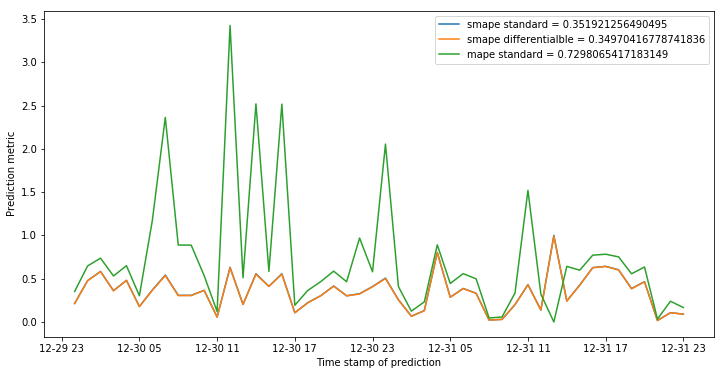

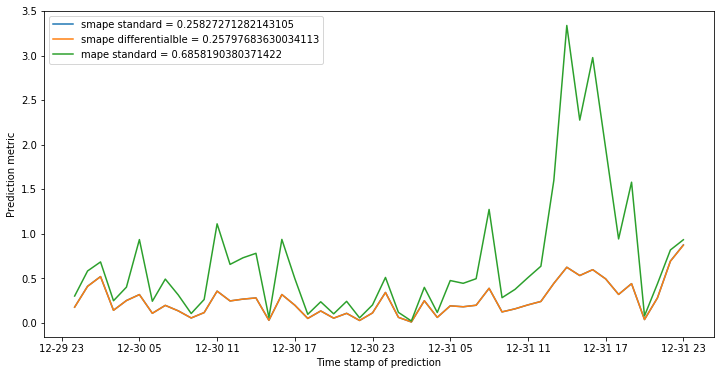

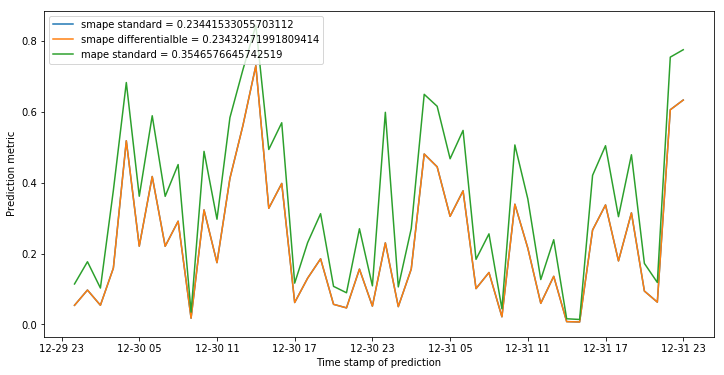

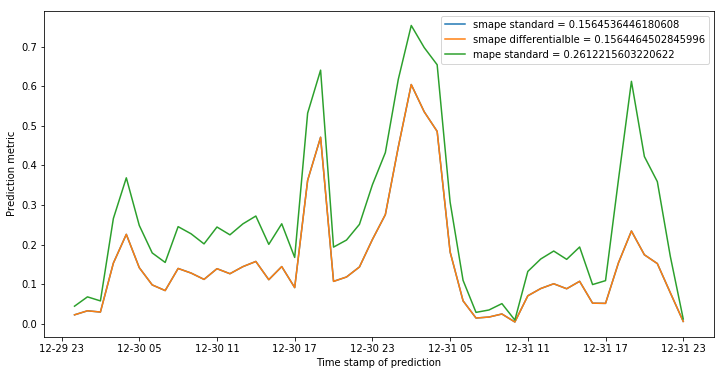

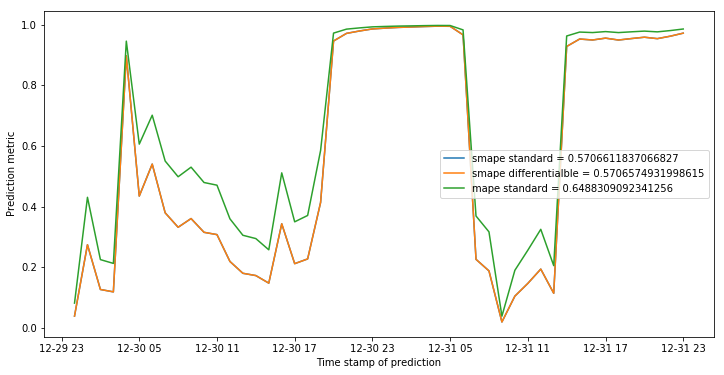

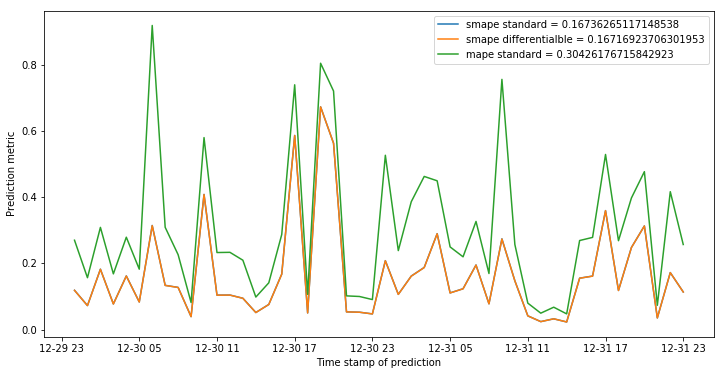

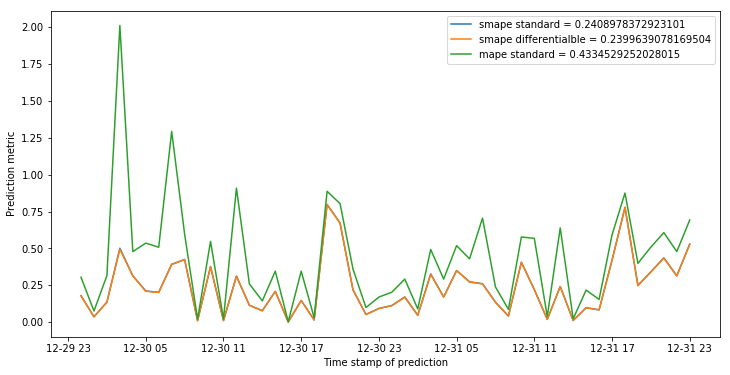

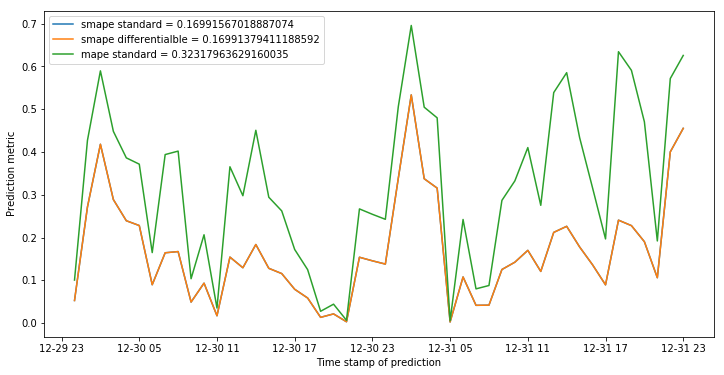

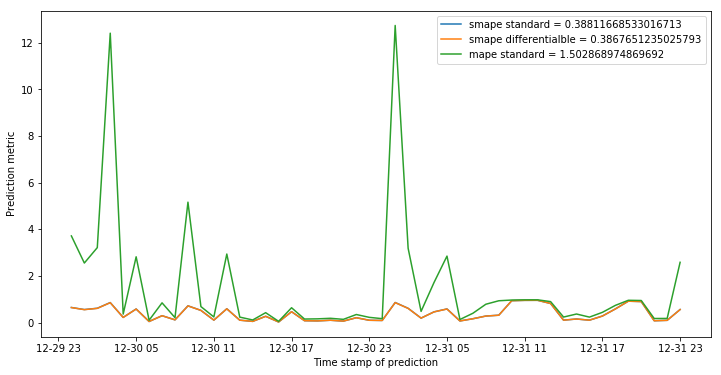

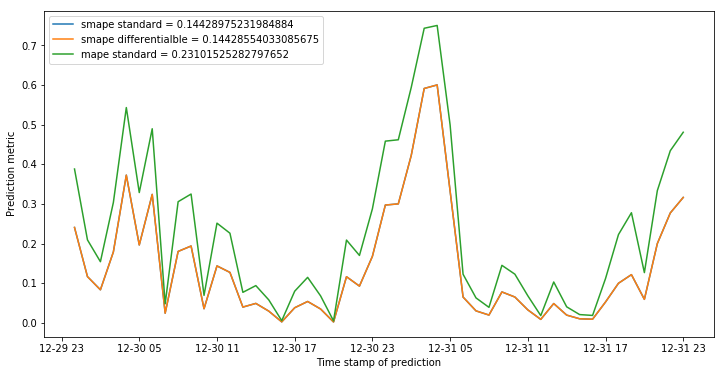

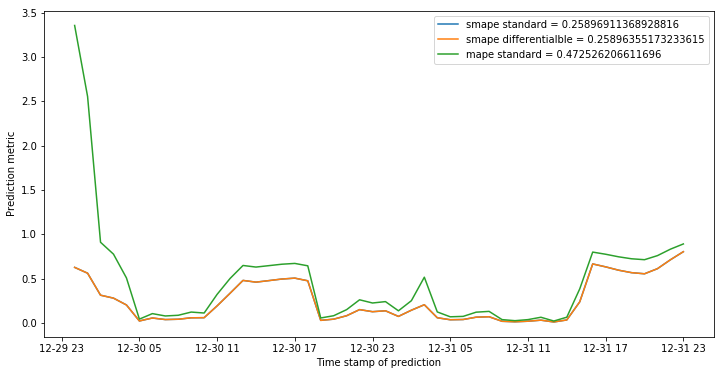

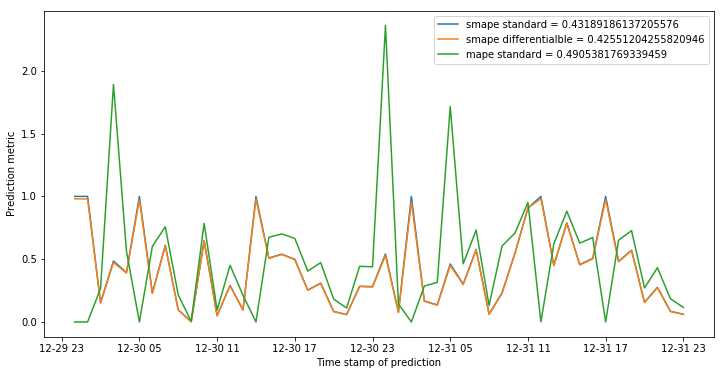

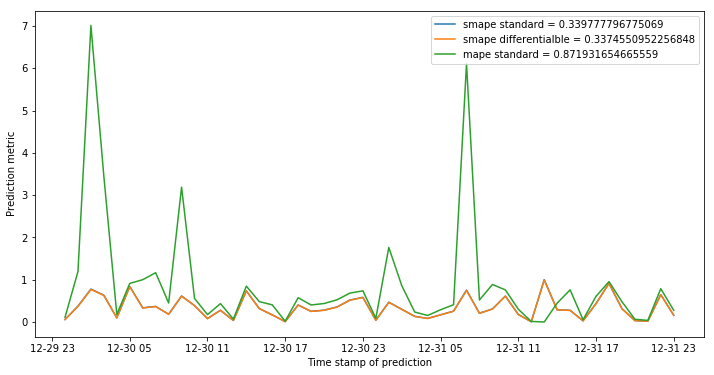

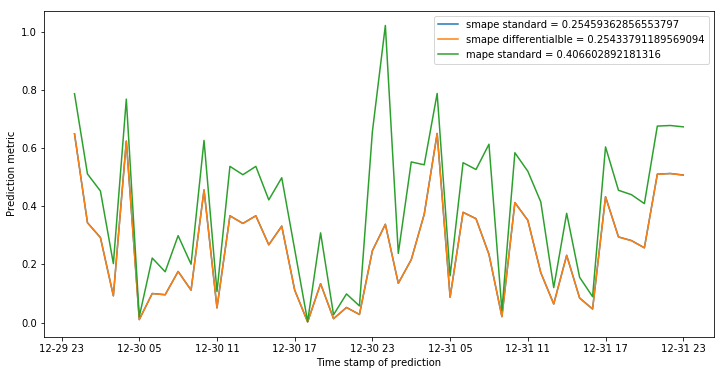

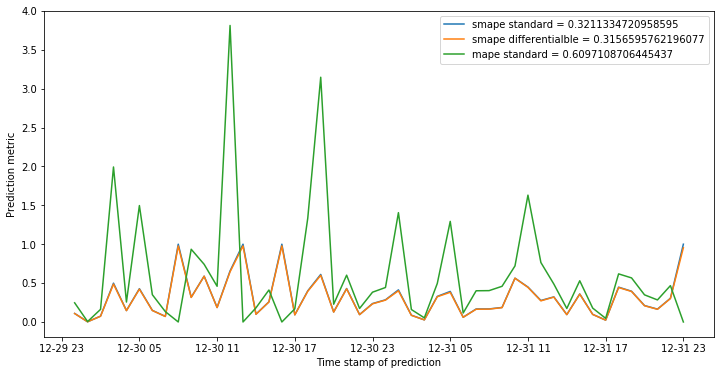

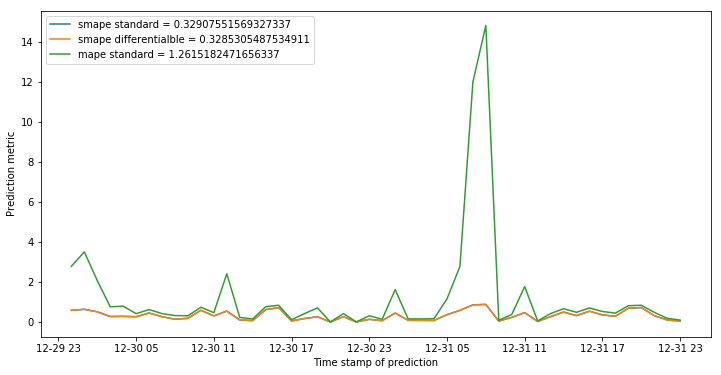

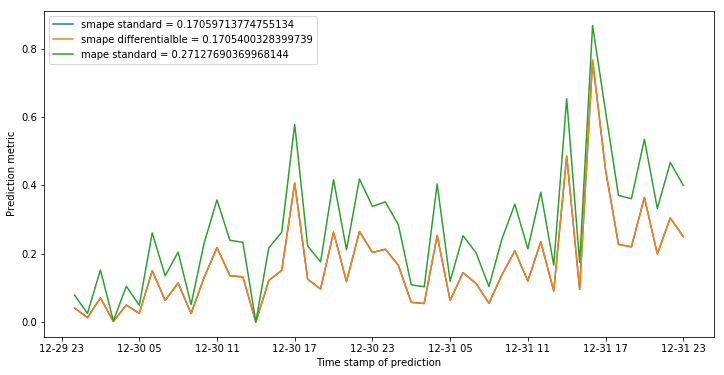

In [25]:
for k in range(0, len(list_of_wiki_pred), 50):
    plot_metrics(time_series_wiki[k][-prediction_length:], list_of_wiki_pred[k][0]['0.5'])


In [26]:
import heapq
# This function characterize time series with FFT.
def characterize_ts(ts,window):
    y = ts.values # signal
    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    # We only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval.
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)
    
    # Locate the largest 15 peaks, use them to characterise the time series.
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15,yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a,b : np.abs(a/b - 1) < 0.05
    ts_type = ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # Here we define a peak in frequency domain.
        if amp[counter] > (mean + 3*std):
            amp_norm = (amp[counter] - mean)/std
            if cycle[value] < 0.01:
                # trend (increasing, decreasing, gaussian pulse)
                report_list[0] = max(amp_norm,report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm,report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm,report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm,report_list[3])
            elif comp(cycle[value], cyc_month):
                report_list[4] = max(amp_norm,report_list[4])

    if sum(report_list[:5]) > 0:
        index = report_list[:5].index(max(report_list[:5])) 
        report_list[5] = ts_type[index]
    else: 
        report_list[5] = ts_type[-1]
        
    # Add a subcategory: a special day seasonality that has a periodic impulse shape.    
    if (report_list[5] == 'hDay' or report_list[5] == 'Day'):
        harmonic = set(range(12))
        all_peak = set()
        for counter, value in enumerate(indx):
            if amp[counter] > (mean + 3*std):
                all_peak.add(int(round(cycle[value])))
        if len(harmonic.intersection(all_peak)) > 10 :
            report_list[5] = ts_type[-2]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

In [27]:
character_list = []
day = 24
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

In [28]:
error_list = []
for i in range(len(list_of_wiki_pred)):
    metric_smape = differentiable_smape(time_series_wiki[i][-prediction_length:].values, 
                                        list_of_wiki_pred[i][0]['0.5'].values)
    error_list.append(metric_smape.mean())
print(sum(error_list)/len(error_list))    

0.2708389339561319


### By classifying the time series into different buckets, we can see how the model performs on different types of time series.

- The major types of time series in the wiki dataset are: Day seasonality, Trend seasonality. We also observe a small population of HalfDay seasonality time series as well.


- But we see the model performance varies to some extent according to the scale or type.

trend  smape  0.3143839208494212  number of series  296
hDay  smape  0.21014433898336468  number of series  4
Day  smape  0.1974553594852364  number of series  356
Week  smape  0.271484372179037  number of series  1
Month  smape  0.23434454128935928  number of series  5
spike  smape  0.33353275487381007  number of series  2
DayImpulse  smape  0.3654854630078227  number of series  143


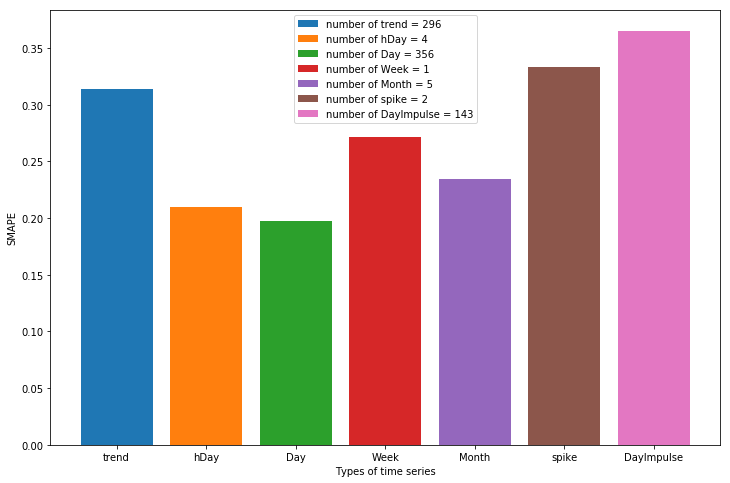

In [29]:
ans = {}
# we have ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
ans['trend'] = []
ans['hDay'] = []
ans['Day'] = []
ans['Week'] = []
ans['Month'] = []
ans['spike'] = []
ans['DayImpulse'] = []

for i in range(len(error_list)):
    ans[character_list[i][5]].append(error_list[i])

plt.figure(figsize=(12,8))  
for key, value in ans.items():
    if value:
        print(key, ' smape ', np.mean(value), ' number of series ', len(value))
        plt.bar(key, np.mean(value), label = 'number of {} = {}'.format(key, len(value)))
plt.xlabel('Types of time series')
plt.ylabel('SMAPE')
plt.legend()
plt.show()

### Examine Trend type time series, the error distribution, and will the scale affect the error?

- By plotting the scale (mean amplitude, consistent with the deepAR paper) vs the corresponding SMAPE, we see a correlation here.

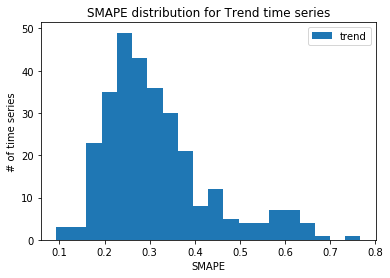

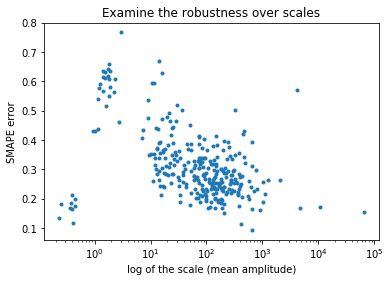

In [30]:
plt.figure()
plt.hist(ans['trend'], bins = 20, label = 'trend')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for Trend time series')
plt.legend()
plt.show()

trend_mean = []
trend_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'trend'):
        trend_mean.append(character_list[index][6])
        trend_error.append(error_list[index])
        if (error < 0.15 and character_list[index][6] > 1000):
            good_index.append(index)
        elif (error > 0.5 and character_list[index][6] > 1000):
            bad_index.append(index) 

plt.figure()
plt.plot((trend_mean), trend_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

In [31]:
for k in good_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Trend time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show() 
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

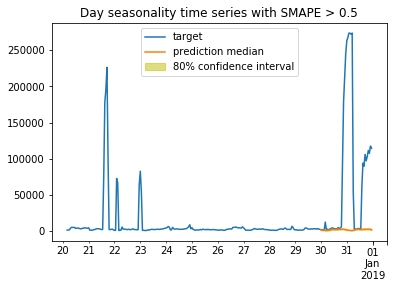

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[10.134296086414391, 0, 0, 0, 0, 'trend', 4120.293378995434, 12058.395374869264]


In [32]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE > 0.5')
    plt.legend(loc = 'best')
    plt.show()
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Examine the Day seasonality type time series, the error distribution, and will the scale affect the error?

- Similar to the trend type, we see a correlation between the scale and the SMAPE. The model performs better for larger scales (i.e. time series for popular wiki projects).

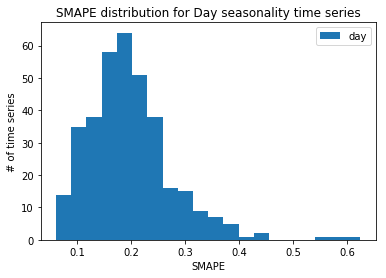

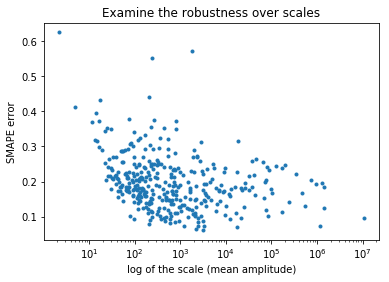

In [33]:
plt.figure()
plt.hist(ans['Day'], bins = 20, label = 'day')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for Day seasonality time series')
plt.legend()
plt.show()

day_mean = []
day_error = []
bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'Day'):
        day_mean.append(character_list[index][6])
        day_error.append(error_list[index])
        if error < 0.15:
            good_index.append(index)
        elif error > 0.4:
            bad_index.append(index)    

plt.figure()
plt.plot((day_mean), day_error, '.')
plt.xscale('log')
plt.xlabel('log of the scale (mean amplitude)')
plt.ylabel('SMAPE error')
plt.title('Examine the robustness over scales')
plt.show()

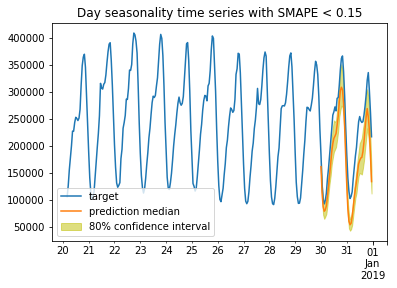

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[9.366193632172015, 19.49257953361858, 56.442911965260635, 4.485444168711687, 0, 'Day', 243617.53253424657, 96089.60703928991]


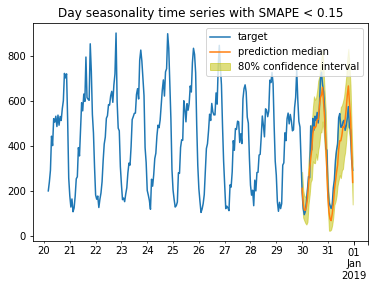

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[22.944572351905297, 15.752315259765247, 48.73718145183857, 5.853756054941323, 0, 'Day', 467.1590182648402, 273.0487724441968]


In [34]:
for k in good_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE < 0.15')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

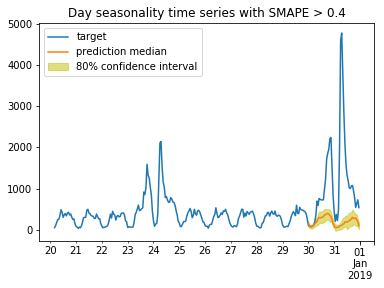

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[19.41042533470602, 15.140689277679058, 37.73321661125712, 4.210930146142056, 0, 'Day', 244.64429223744293, 222.84251652370511]


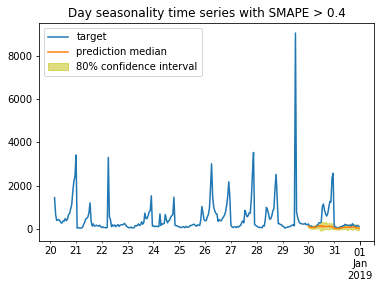

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[20.229056686727457, 8.346676489623686, 20.936862727187588, 0, 0, 'Day', 211.4929223744292, 220.72309496992733]


In [35]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length*2:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('Day seasonality time series with SMAPE > 0.4')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Examine DayImpulse type time series, why it has such high error?

Find the ones with high SMAPE, and see how the actual and prediction compare to each other.

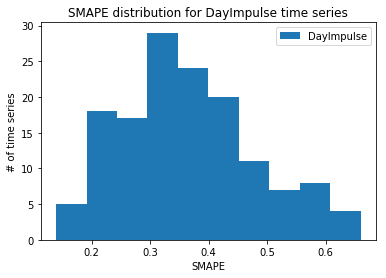

In [36]:
plt.figure()
plt.hist(ans['DayImpulse'], label = 'DayImpulse')
plt.xlabel('SMAPE')
plt.ylabel('# of time series')
plt.title('SMAPE distribution for DayImpulse time series')
plt.legend()
plt.show()

bad_index = []
good_index = []
for index, error in enumerate(error_list):
    if (character_list[index][5] == 'DayImpulse' and error > 0.6):
        bad_index.append(index)
    elif (character_list[index][5] == 'DayImpulse' and error < 0.25):
        good_index.append(index)

#### Now we take a look at the good and bad examples: we plot shorter length (only keep the context + prediction) to better zoom in.

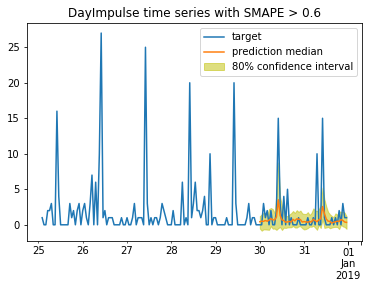

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[6.00386687844202, 18.29357525086545, 15.94794989275925, 0, 0, 'DayImpulse', 1.957648401826484, 4.5771330526216465]


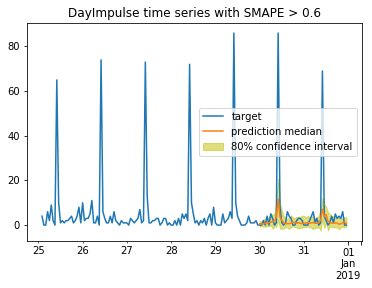

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[5.5187904167550625, 12.796424562541779, 7.733882464198612, 0, 0, 'DayImpulse', 7.672146118721461, 40.26232532529205]


In [37]:
for k in bad_index[:2]:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE > 0.6')
    plt.legend(loc = 'best')
    plt.show()    
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

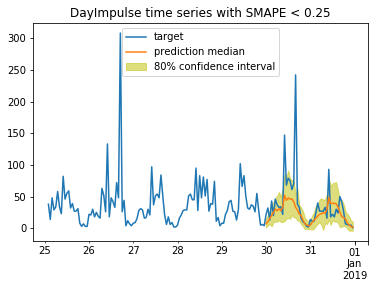

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[15.080828018258563, 15.588152393910072, 40.16709438797245, 0, 0, 'DayImpulse', 37.04372146118722, 36.793522134775756]


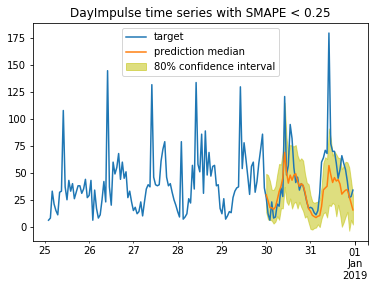

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[14.38890491514568, 14.707319453607008, 40.21717100640066, 0, 0, 'DayImpulse', 46.592351598173515, 53.83259745551839]


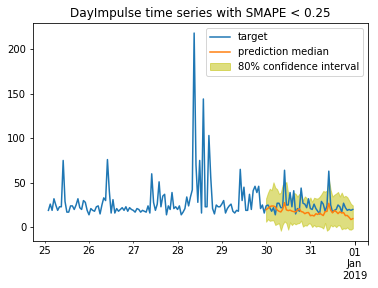

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[7.098609275007841, 9.343190639375914, 11.104972458595583, 0, 0, 'DayImpulse', 25.308333333333334, 32.176245158087724]


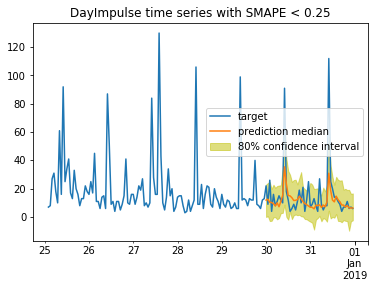

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[10.726859426393156, 14.690960554740775, 13.995919318933618, 0, 0, 'DayImpulse', 21.86472602739726, 26.71648606933508]


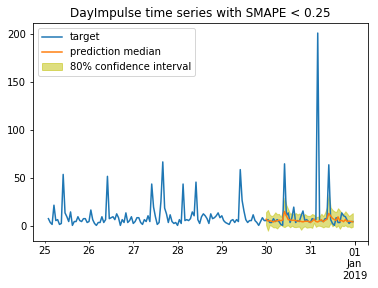

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[7.247921445456519, 12.185368206390443, 14.232426593055683, 0, 0, 'DayImpulse', 14.349885844748858, 27.088862308598035]


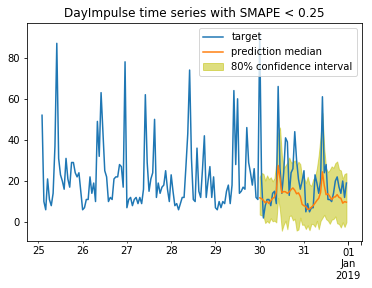

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[16.099629201152094, 13.243552852247074, 21.064284911184526, 0, 0, 'DayImpulse', 21.901826484018265, 22.470923807340018]


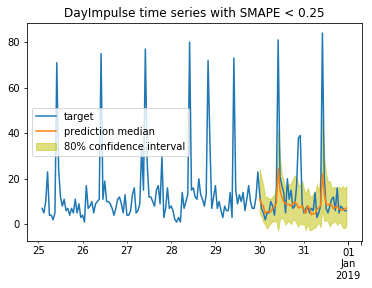

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[8.897257057409654, 10.991042635142541, 10.383273755845869, 0, 0, 'DayImpulse', 21.59337899543379, 42.257994320793074]


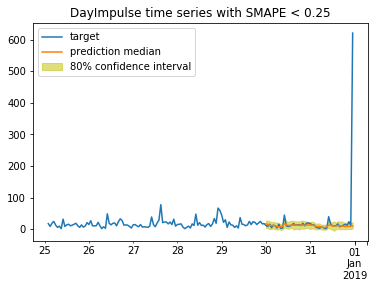

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[15.040644912887895, 16.236833835138043, 25.19340080119428, 12.37118813428284, 0, 'DayImpulse', 21.888013698630136, 19.71115954647212]


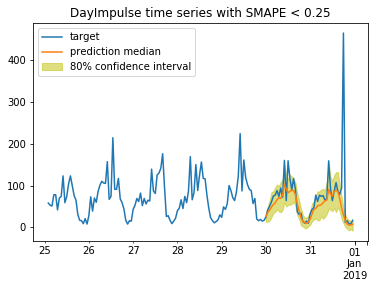

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.41978634020924, 22.078983942941534, 48.934318457195836, 0, 0, 'DayImpulse', 76.06324200913242, 55.232781531436764]


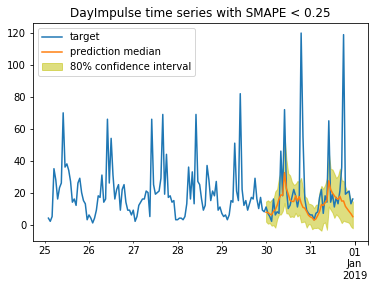

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.100463166282875, 8.81399172160262, 41.411118655562746, 0, 0, 'DayImpulse', 24.02488584474886, 21.49378845942629]


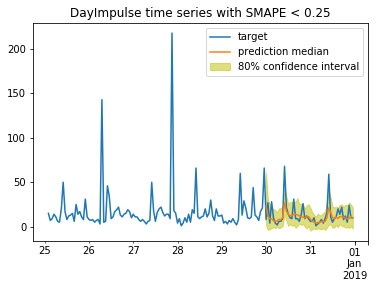

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.215686426243055, 20.488510351694302, 27.06954921527189, 10.99231504051622, 0, 'DayImpulse', 21.813356164383563, 26.70226470422189]


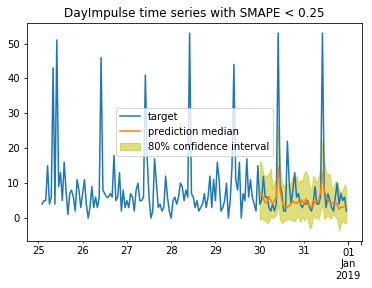

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[6.032516561711532, 8.832123791574181, 5.449601993632414, 0, 0, 'DayImpulse', 12.216438356164383, 29.737895417200818]


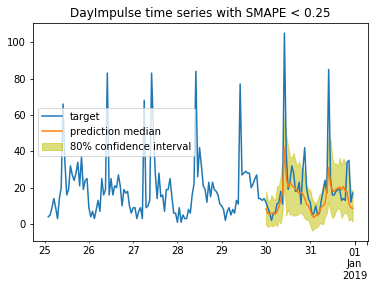

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[23.853448601806555, 15.749886595851926, 34.96553938362958, 12.65042428612678, 0, 'DayImpulse', 35.541438356164385, 34.233763537882616]


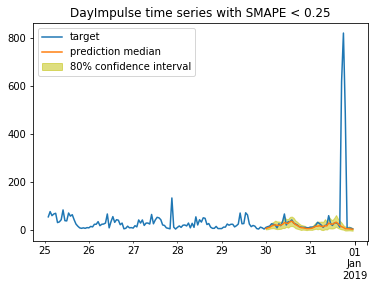

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[25.730774012753052, 9.38826448855617, 31.710868890636725, 0, 0, 'DayImpulse', 19.22077625570776, 24.164308699454683]


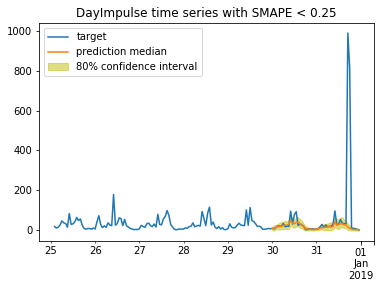

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[22.267108678432734, 10.18693586074185, 37.6458581101828, 0, 0, 'DayImpulse', 25.284474885844748, 30.70983862208616]


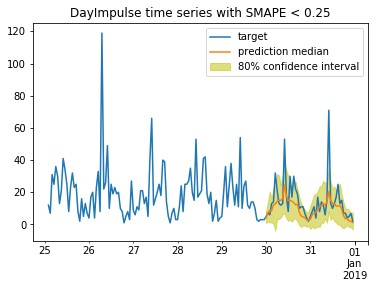

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[11.496852764990484, 0, 34.69839895142544, 0, 0, 'DayImpulse', 17.05890410958904, 19.68462999804047]


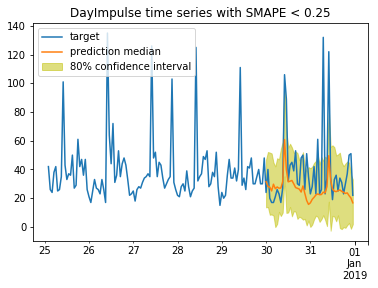

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[0, 9.236257774375815, 26.82350896692998, 0, 0, 'DayImpulse', 37.32374429223744, 31.688621074685134]


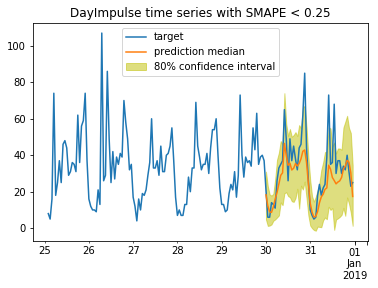

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[6.634792092268229, 33.53318591839137, 40.81946181510605, 4.917645753059107, 3.877133391793806, 'DayImpulse', 38.87237442922375, 25.34914937062269]


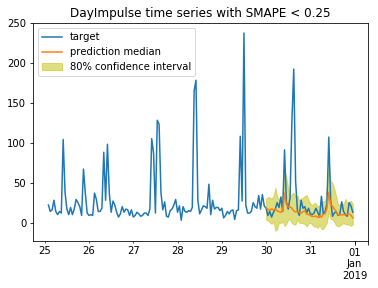

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[13.706826261666851, 13.55806919958897, 13.974726836744749, 0, 0, 'DayImpulse', 27.66118721461187, 38.7657353581733]


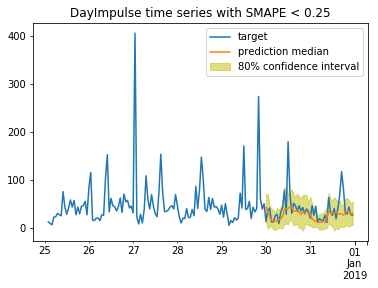

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[12.57497447320185, 23.45363372874239, 34.854525838691835, 4.99456733429738, 0, 'DayImpulse', 39.30776255707762, 26.281202964103915]


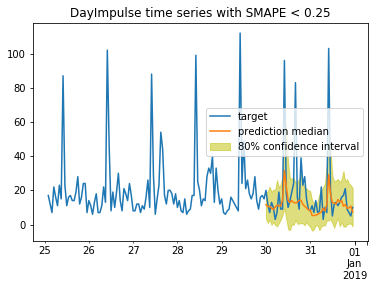

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[5.954786964320144, 12.067609860791299, 12.44137344961757, 0, 0, 'DayImpulse', 21.474543378995435, 34.95010521076512]


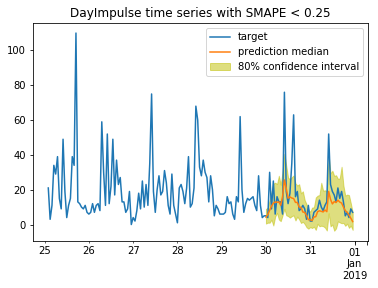

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[5.4435417709290785, 5.295887179709204, 35.894014888455956, 0, 0, 'DayImpulse', 16.623173515981737, 15.2352447360139]


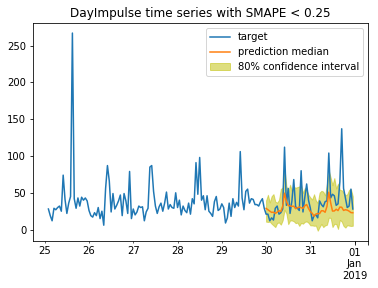

[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]
[19.116368936260532, 11.46517795794496, 19.60445843211784, 0, 0, 'DayImpulse', 35.43550228310502, 39.26090803082942]


In [38]:
for k in good_index:
    plt.figure()
    time_series_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k][0]['0.1']
    p90 = list_of_wiki_pred[k][0]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k][0]['0.5'].plot(label='prediction median')
    plt.title('DayImpulse time series with SMAPE < 0.25')
    plt.legend(loc = 'best')
    plt.show()   
    print('[trend score, half day score, day score, week score, month score, strongest characteristic, time mean, time std]')
    print(character_list[k])

### Delete endpoint

In [39]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-02-05-03-33-24-323
